In [7]:
import random
import csv
import time
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from utils import *

In [9]:
um= pd.read_csv('csv\\pseudo_random_utility_matrix.csv',index_col=0)

In [10]:
def predict(utility_matrix, q_sim_neighbors, u_sim_neighbors, u_sim_weight, q_sim_weight):
    utility_matrix_copy = utility_matrix.fillna(0)
    output = utility_matrix_copy.copy()
    
    # Get the columns of the utility matrix
    columns = utility_matrix.axes[1]
    
    # Create similarity matrices for users and querries using cosine similarity and standardizing the utility matrix
    q_sim_matrix = query_similarity(utility_matrix_copy,q_sim_neighbors,standardize_matrix=True)
    u_sim_matrix = user_similarity(utility_matrix_copy,u_sim_neighbors,standardize_matrix=True)
    
    
    # Find all the locations in the utility matrix where there is a missing value
    scores_to_predict = np.array(np.where(utility_matrix.fillna(0)== 0)).T
    for i,j in scores_to_predict:
        # Calculate the user similarity score and query similarity score
        q_score = np.dot(utility_matrix_copy.iloc[i], q_sim_matrix[j])/np.dot(q_sim_matrix[j], utility_matrix.iloc[i].notna())
        u_score = np.dot(utility_matrix_copy[columns[j]], u_sim_matrix[i])/np.dot(u_sim_matrix[i], utility_matrix[columns[j]].notna())
        
        # Make predictions by taking a weighted sum of the user similarity score and query similarity score
        output.iloc[i,j] = round(u_sim_weight*u_score + q_sim_weight*q_score, 2)
    return output


In [11]:
import numpy as np
print('Masking 20 % of the data to test')
mask = np.ones((2000,2000))
mask[1600:,1600:]=0
data_to_test=np.array(um)
data_to_test[np.logical_not(mask)] = None
data_to_test_df=pd.DataFrame(data_to_test,columns= um.axes[1],index=um.axes[0])
print('Mask done')

Masking 20 % of the data to test
Mask done


In [ ]:
#search for the best u_sim_neighbors
x1=np.arange(100,1100,100)
y1=[]
for i in x1:
    print('u_sim_neighbors:',i)
    pred=predict(data_to_test_df,q_sim_weight=0,q_sim_neighbors=500, u_sim_neighbors=i,u_sim_weight=1)
    pred1=pred[um.notna()]
    y_pred=np.array(pred1.fillna(0))[np.logical_not(mask)]
    y_truth=np.array(um.fillna(0))[np.logical_not(mask)]
    y1.append(sqrt(mean_squared_error(y_pred=y_pred,y_true=y_truth)))
    print('RMSE:',sqrt(mean_squared_error(y_pred=y_pred,y_true=y_truth)))

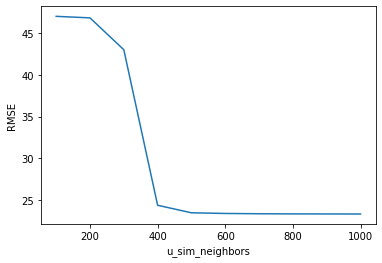

In [10]:
plt.plot(x1,y1)
plt.ylabel('RMSE')
plt.xlabel('u_sim_neighbors')
plt.show()


In [ ]:
#search for the best q_sim_neighbors
x2=np.arange(100,1100,100)
y2=[]
for i in x2:
    print('q_sim_neighbors:',i)
    pred=predict(data_to_test_df,q_sim_weight=1,q_sim_neighbors=i, u_sim_neighbors=200,u_sim_weight=0)
    pred1=pred[um.notna()]
    y_pred=np.array(pred1.fillna(0))[np.logical_not(mask)]
    y_truth=np.array(um.fillna(0))[np.logical_not(mask)]
    y2.append(sqrt(mean_squared_error(y_pred=y_pred,y_true=y_truth)))
    print('RMSE:',sqrt(mean_squared_error(y_pred=y_pred,y_true=y_truth)))

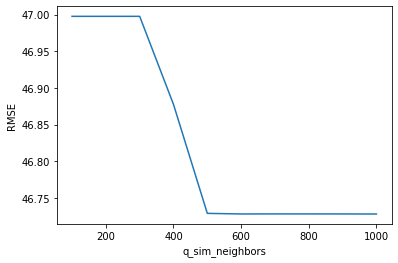

In [12]:
plt.plot(x2,y2)
plt.ylabel('RMSE')
plt.xlabel('q_sim_neighbors')
plt.show()

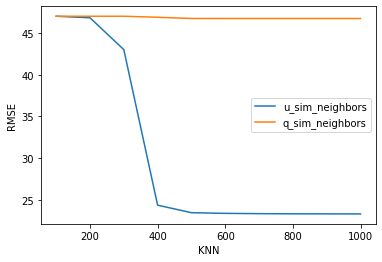

In [17]:
plt.plot(x1, y1, label = "u_sim_neighbors")
plt.plot(x2, y2, label = "q_sim_neighbors")
plt.ylabel('RMSE')
plt.xlabel('KNN')


In [ ]:
#search for the best weights
x=np.arange(0,1.1,0.1)
y=[]
for i in x:
    print('q_sim_weight:',i)
    pred=predict(data_to_test_df,q_sim_weight=i,q_sim_neighbors=600, u_sim_neighbors=600,u_sim_weight=1-i)
    pred1=pred[um.notna()]
    y_pred=np.array(pred1.fillna(0))[np.logical_not(mask)]
    y_truth=np.array(um.fillna(0))[np.logical_not(mask)]
    y.append(sqrt(mean_squared_error(y_pred=y_pred,y_true=y_truth)))
    print('RMSE:',sqrt(mean_squared_error(y_pred=y_pred,y_true=y_truth)))

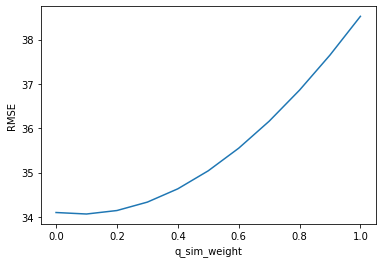

In [22]:
plt.plot(x,y)
plt.ylabel('RMSE')
plt.xlabel('q_sim_weight')
plt.show()

In [12]:
#fill the matrix with the best hyperparmeters
pred=predict(data_to_test_df,q_sim_weight=0,q_sim_neighbors=500, u_sim_neighbors=400,u_sim_weight=1)
pred.to_csv('./csv/predicted_utility_matrix.csv')

In [13]:
pred.isna().sum().sum()

0

In [60]:
def top_k_queries(user_id, k: int, predictions):

    user_predictions = predictions.loc[user_id]
    user_predictions = user_predictions.sort_values(ascending=False)
    return(user_predictions[:k].index.to_list())

In [6]:
pred=pd.read_csv('csv\predicted_utility_matrix.csv',index_col=0)
top_k_queries('U100',5,pred)

['Q437', 'Q1404', 'Q1154', 'Q461', 'Q202']

In [ ]:
x3=range(100,1100,100)
y3=[]
for i in x3:
    sim=0
    for j in range(1601,2001):
        sim+=jaccard_similarity(top_k_queries('U'+str(j),i,um.fillna(0)),top_k_queries('U'+str(j),i,pred1.fillna(0)))
    y3.append(sim/400)

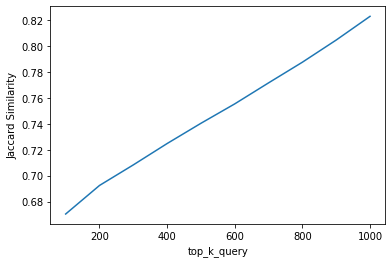

In [84]:
plt.plot(x3,y3,)
plt.xlabel('top_k_query')
plt.ylabel('Jaccard Similarity')
plt.savefig('topk.png')